## Imports

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import warnings
import os.path
import random
import math
import time

## Epoch and Directories

In [65]:
EPOCHS = 50

# For simple regression problem
TRAINING_POINTS = 1000

# For fashion-MNIST and similar problems
DATA_ROOT = '/data/cs3450/data/'
FASHION_MNIST_TRAINING = '/data/cs3450/data/fashion_mnist_flattened_training.npz'
FASHION_MNIST_TESTING = '/data/cs3450/data/fashion_mnist_flattened_testing.npz'
CIFAR10_TRAINING = '/data/cs3450/data/cifar10_flattened_training.npz'
CIFAR10_TESTING = '/data/cs3450/data/cifar10_flattened_testing.npz'
CIFAR100_TRAINING = '/data/cs3450/data/cifar100_flattened_training.npz'
CIFAR100_TESTING = '/data/cs3450/data/cifar100_flattened_testing.npz'


## Trying the GPU Method

In [66]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu().
       https://d2l.ai/chapter_deep-learning-computation/use-gpu.html
    """
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
DEVICE=try_gpu()
DEVICE

device(type='cuda', index=0)

In [67]:
def create_linear_training_data():
    """
    This method simply rotates points in a 2D space.
    Be sure to use L2 regression in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    y = torch.cat((-x2, x1), axis=0)
    return x, y


def create_folded_training_data():
    """
    This method introduces a single non-linear fold into the sort of data created by create_linear_training_data. Be sure to REMOVE the final softmax layer before testing on this data!
    Be sure to use L2 regression in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    x2 *= 2 * ((x2 > 0).float() - 0.5)
    y = torch.cat((-x2, x1), axis=0)
    return x, y


def create_square():
    """
    This is the square example that we looked at in class.
    insideness is true if the points are inside the square.
    :return: (points, insideness) the dataset. points is a 2xN array of points and insideness is true if the point is inside the square.
    """
    win_x = [2,2,3,3]
    win_y = [1,2,2,1]
    win = torch.tensor([win_x,win_y],dtype=torch.float32)
    win_rot = torch.cat((win[:,1:],win[:,0:1]),axis=1)
    t = win_rot - win # edges tangent along side of poly
    rotation = torch.tensor([[0, 1],[-1,0]],dtype=torch.float32)
    normal = rotation @ t # normal vectors to each side of poly
        # torch.matmul(rotation,t) # Same thing

    points = torch.rand((2,2000),dtype = torch.float32)
    points = 4*points

    vectors = points[:,np.newaxis,:] - win[:,:,np.newaxis] # reshape to fill origin
    insideness = (normal[:,:,np.newaxis] * vectors).sum(axis=0)
    insideness = insideness.T
    insideness = insideness > 0
    insideness = insideness.all(axis=1)
    return points, insideness

In [68]:
def load_dataset_flattened(train=True,dataset='Fashion-MNIST',download=False):
    """
    :param train: True for training, False for testing
    :param dataset: 'Fashion-MNIST', 'CIFAR-10', or 'CIFAR-100'
    :param download: True to download. Keep to false afterwords to avoid unneeded downloads.
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    if dataset == 'Fashion-MNIST':
        if train:
            path = FASHION_MNIST_TRAINING
        else:
            path = FASHION_MNIST_TESTING
        num_labels = 10
    elif dataset == 'CIFAR-10':
        if train:
            path = CIFAR10_TRAINING
        else:
            path = CIFAR10_TESTING
        num_labels = 10
    elif dataset == 'CIFAR-100':
        if train:
            path = CIFAR100_TRAINING
        else:
            path = CIFAR100_TESTING
        num_labels = 100
    else:
        raise ValueError('Unknown dataset: '+str(dataset))

    if os.path.isfile(path):
        print('Loading cached flattened data for',dataset,'training' if train else 'testing')
        data = np.load(path)
        x = torch.tensor(data['x'],dtype=torch.float32)
        y = torch.tensor(data['y'],dtype=torch.float32)
        pass
    else:
        class ToTorch(object):
            """Like ToTensor, only to a numpy array"""

            def __call__(self, pic):
                return torchvision.transforms.functional.to_tensor(pic)

        if dataset == 'Fashion-MNIST':
            data = torchvision.datasets.FashionMNIST(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        elif dataset == 'CIFAR-10':
            data = torchvision.datasets.CIFAR10(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        elif dataset == 'CIFAR-100':
            data = torchvision.datasets.CIFAR100(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        else:
            raise ValueError('This code should be unreachable because of a previous check.')
        x = torch.zeros((len(data[0][0].flatten()), len(data)),dtype=torch.float32)
        for index, image in enumerate(data):
            x[:, index] = data[index][0].flatten()
        labels = torch.tensor([sample[1] for sample in data])
        y = torch.zeros((num_labels, len(labels)), dtype=torch.float32)
        y[labels, torch.arange(len(labels))] = 1
        np.savez(path, x=x.detach().numpy(), y=y.detach().numpy())
    return x, y

In [69]:
# TODO: Select your datasource.
dataset = 'Fashion-MNIST'
#ataset = 'CIFAR-10'
# dataset = 'CIFAR-100'

#x_train, y_train = create_linear_training_data()
#x_train, y_train = create_folded_training_data()
#points_train, insideness_train = create_square()
x_train, y_train = load_dataset_flattened(train=True, dataset=dataset, download=False)
# Move selected datasets to GPU
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

Loading cached flattened data for Fashion-MNIST training


In [70]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [71]:
y_train

tensor([[0., 1., 1.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [72]:
# TODO: Test the accuracy of your network
#x_test, y_test = create_linear_training_data()
x_test, y_test = load_dataset_flattened(train=False, dataset=dataset, download=False)

# Move the selected datasets to the GPU
x_test = x_test.to(DEVICE)
y_test = y_test.to(DEVICE)

Loading cached flattened data for Fashion-MNIST testing


In [73]:
x_test

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [74]:
y_test

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

## Lab 4 - Tuning your Autograd Training Loop

## Gradient Descent

In [75]:
def sgd(params, lr, batceh_size, weight_decay):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param *= weight_decay
            param.grad.zero_()

### Testing/Experiment Cell

In [76]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test.shape)

torch.Size([784, 60000])
torch.Size([10, 60000])
torch.Size([784, 10000])
torch.Size([784, 10000])


## Implementation of ReLU

In [77]:
def relu(x):
    return x * (x > 0)

## Implementation of Linear Regression

In [78]:
def linreg(X,w,b):
    #print("W:", w)
    #print("B:", b)
    return ((torch.matmul(X,w) + b))

## Implementation of MiniBatches

In [79]:
def data_iter(batch_size, features, labels):
    n = len(features)
    iss = list(range(n))
    random.shuffle(iss)
    for i in range(0, n, batch_size):
        b = torch.tensor(iss[i:min(i + batch_size, n)])
        yield features[b], labels[b]

## Stable Softmax

In [80]:
def stablesoftmax(x):
    x = x.float()
    f = x - torch.max(x)
    log = f - torch.log(torch.sum(torch.exp(f)))
    return log

## Softmax Implementation

In [81]:
def softmax(x):
    x = x.float()
    m = torch.max(x.float(),0)
    v = torch.exp(x.float() - m.values)
    b = torch.sum(v,0).float()
    t = (v / b).float()
    return t

## Cross Entropy Implementation

In [82]:
def cross_entropy(X,y):
    #epsilon = 1e-5
    y_hat = stablesoftmax(X)
    prob = y * (y_hat)
    return -torch.sum(prob) / y.shape[0]

## Accuracy

In [83]:
def accuracy(y_hat, y):
    y = torch.argmax(y, dim=0)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum()) / 10000

## Training Loop For Fashion MNIST

Epoch:  1 
Loss: 124.0457992553711 
Accuracy:  0.0592
Epoch:  2 
Loss: 77.9225845336914 
Accuracy:  0.0577
Epoch:  3 
Loss: 32.828857421875 
Accuracy:  0.1338
Epoch:  4 
Loss: 11.437917709350586 
Accuracy:  0.3204
Epoch:  5 
Loss: 11.424445152282715 
Accuracy:  0.3387
Epoch:  6 
Loss: 11.414013862609863 
Accuracy:  0.3635
Epoch:  7 
Loss: 11.404820442199707 
Accuracy:  0.3837
Epoch:  8 
Loss: 11.396069526672363 
Accuracy:  0.3876
Epoch:  9 
Loss: 11.385401725769043 
Accuracy:  0.3977
Epoch:  10 
Loss: 11.375394821166992 
Accuracy:  0.428
Epoch:  11 
Loss: 11.369349479675293 
Accuracy:  0.4472
Epoch:  12 
Loss: 11.357158660888672 
Accuracy:  0.4563
Epoch:  13 
Loss: 11.348383903503418 
Accuracy:  0.479
Epoch:  14 
Loss: 11.339290618896484 
Accuracy:  0.4948
Epoch:  15 
Loss: 11.331463813781738 
Accuracy:  0.5081
Epoch:  16 
Loss: 11.320676803588867 
Accuracy:  0.5405
Epoch:  17 
Loss: 11.311068534851074 
Accuracy:  0.5551
Epoch:  18 
Loss: 11.301878929138184 
Accuracy:  0.5561
Epoch:  1

Epoch:  148 
Loss: 10.50490951538086 
Accuracy:  0.6956
Epoch:  149 
Loss: 10.502558708190918 
Accuracy:  0.6907
Epoch:  150 
Loss: 10.500123977661133 
Accuracy:  0.695


Text(0.5, 1.0, 'Epoch vs Accuracy')

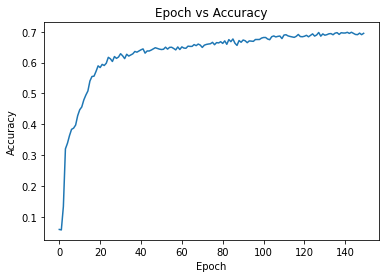

In [114]:
# %%time
#for the first layer
hidden_layers = 200
flw = np.random.rand(784,hidden_layers) * 0.1
tflw = torch.tensor(flw, requires_grad=True, device=DEVICE)
#print("First Layer Weights: ", tflw)
flb = torch.zeros(hidden_layers, requires_grad=True, device=DEVICE)
#print(flb)

#for the second layer
slw = np.random.rand(hidden_layers,10) * 0.1
tslw = torch.tensor(slw, requires_grad=True, device=DEVICE)
#print(tslw)
slb = torch.zeros(10, requires_grad=True, device=DEVICE)
#print(slb)

#training parameters

#learning rate
lr = 0.0001
#number of epoch
num_epoch = 150
#peforming linear regression
net = linreg
#performing linear regression 2
net2 = linreg
#batch size
batch_size = 20
#using the weight decay within our sgd
weight_decay = 1 - 1e-7

acc = []

for epoch in range(num_epoch):
    for X, y in data_iter(batch_size, x_train.T, y_train.T):
        l = cross_entropy((net2(net(X,tflw.float(),flb.float()),tslw.float(), slb.float())), y).to(DEVICE)
        l.sum().backward()
        sgd([tflw, flb], lr, batch_size, weight_decay)
        sgd([tslw, slb], lr, batch_size, weight_decay)
    with torch.no_grad():
        soft = softmax(net2(net(x_test.T, tflw.float(), flb.float()), tslw.float(), slb.float())).to(DEVICE)
        train_l = cross_entropy(net2(net(x_test.T, tflw.float(), flb.float()), tslw.float(), slb.float()),y_test.T).to(DEVICE)
        a = accuracy(soft, y_test)
        acc.append(a)
        print("Epoch: ", epoch+1, "\nLoss:", float(train_l.mean()),"\nAccuracy: ", a)

plt.plot(acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")

## Training Loop For CIFAR 10

In [45]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([3072, 50000])
torch.Size([10, 50000])
torch.Size([3072, 10000])
torch.Size([10, 10000])


# Testing Runs For Fashion MNIST

## Test Run: 1

Motivation For This Run: 
- This is the default run, we are testing the network with my version of the minimal number of layers and little attention to the optimial numbers for learning rate and regularization, a low amount of epoch so the network doesn't have much time to go over the data and learn, so overall a poorly optimized network as a baseline.

Number of layers: 
- Input: 784
- Hidden: 10
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 804

Learning Rate:
- 0.01

Batch Size:
- 100

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 5

Test Accuracy: 
- Accuracy: 0.1966

GPU Memory Usage: 
- 1186MiB

Acutal Training Time:
- Time: 5.66s

![training](one.png)


## Test Run: 2

Motivation For This Run: 
- I have increased the number of epoch within the network so the model can make more passes through the network and hopefully learn more of the data and increase the accuracy of the network overall. 

Number of layers: 
- Input: 784
- Hidden: 10
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 804

Learning Rate:
- 0.01

Batch Size:
- 100

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 10

Test Accuracy: 
- Accuracy: 0.58

GPU Memory Usage: 
- 1189MiB

Actual Training Time:
- Time: 11.5 

![](two.png)

## Test Run: 3

Motivation For This Run: 
- Keeping the epoch at 10, I want to see if we increaase the incrementation of the amount of hidden layers to 50, this should increase the time complexity but also we able to solve more complex problems which might be able to do better on this dataset.

Number of layers: 
- Input: 784
- Hidden: 50
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 814

Learning Rate:
- 0.01

Batch Size:
- 100

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 10

Test Accuracy: 
- Accuracy: 0.45sc

GPU Memory Usage: 
- 1190MiB

Actual Training Time:
- Time: 12.6s 

![](three.png)

## Test Run: 4

Motivation For This Run: 
- By noticing the increase of the accuracy by just more hidden layer nodes, I will add 50 more hidden layer nodes, and increase the amount of epochs so the model has more iterations through the dataset. This should increase accuracy significantly.

Number of layers: 
- Input: 784
- Hidden: 100
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 894

Learning Rate:
- 0.01

Batch Size:
- 100

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 50

Test Accuracy: 
- Accuracy: 0.69

GPU Memory Usage: 
- 1190MiB

Actual Training Time:
- Time: 1min 3s 

![](four.png)

## Test Run: 5

Motivation For This Run: 
- Within this run, I saw decent improvement in the last test run in accuracy, so for this run I want to decrease the batch size because since the batches will be smaller, it will be easier to prioritize certain data than combining it with a variety of different values that are included within a greater batch size. Also, we will see how a difference of batch size affect the memory utilization, especially after reading about it in our reflection for the week. Also, as a result might be a longer time to complete the run but reduce the loss marginally.

Number of layers: 
- Input: 784
- Hidden: 100
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 894

Learning Rate:
- 0.01

Batch Size:
- 50

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 50

Test Accuracy: 
- Accuracy: 0.7543

GPU Memory Usage: 
- 1398MiB

Actual Training Time:
- Time: 1min 53s

![](five.png)

## Test Run: 6

Motivation For This Run: 
- In this run I went to decrease the learning rate, a smaller learning rates will require me increase the amount of epoch but the idea of this run is to see if the model can learn and find a more optimial global minima. As a result, I do expect the time to be longer. Also, my prediction is I would have to substantially increase the epochs for this learning rate so I want to see how much the learning rate decreases by. 


Number of layers: 
- Input: 784
- Hidden: 100
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 894

Learning Rate:
- 0.001

Batch Size:
- 50

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 100

Test Accuracy: 
- Accuracy: 0.63

GPU Memory Usage: 
- ~979MiB

Actual Training Time:
- Time: 3min 47s

![](six.png)

## Test Run: 7

Motivation For This Run: 
- In this run, I wanted to increase the amount of hidden nodes within the hidden layer to see if there is any improvement for accuracy and to see if the runtime increases significantly.


Number of layers: 
- Input: 784
- Hidden: 200
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 994

Learning Rate:
- 0.001

Batch Size:
- 50

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 100

Test Accuracy: 
- Accuracy: 0.6914

GPU Memory Usage: 
- ~978MiB

Actual Training Time:
- Time: 3min 50s

![](seven.png)

## Test Run: 8

Motivation For This Run: 
- For this run I wanted to see if I increase the number of epoch and the learning rate to see if the model can achieve a better accuracy


Number of layers: 
- Input: 784
- Hidden: 200
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 994

Learning Rate:
- 0.0001

Batch Size:
- 20

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 150

Test Accuracy: 
- Accuracy: 0.6979

GPU Memory Usage: 
- ~999MiB

Actual Training Time:
- Time: 18min 11s

## Test Run: 9

Motivation For This Run: 
- I wanted to see if more hidden layer nodes would increase the accuracy but it got the same accuracy as the pervious run with only 200 for the amount of nodes more than 100 don't seem to work.


Number of layers: 
- Input: 784
- Hidden: 300
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 994

Learning Rate:
- 0.00001

Batch Size:
- 20

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 100

Test Accuracy: 
- Accuracy: 0.6956

GPU Memory Usage: 
- ~989MiB

Actual Training Time:
- Time: 9min 10s

## Test Run: 10

Motivation For This Run: 
- Changing the learining rate back to a default value, keeping the amount of hidden layers  and changing the regularization value to see if there is the regularization can improve the accuracy. But by the end of my runs, my best accuracy was an 85.


Number of layers: 
- Input: 784
- Hidden: 300
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 994

Learning Rate:
- 0.05

Batch Size:
- 20

Regularization Constant:
- 1 - 1e-9

How long the network trained(epoch, or samples seen):
- Epoch: 100

Test Accuracy: 
- Accuracy: 0.85

GPU Memory Usage: 
- ~998MiB

Actual Training Time:
- Time: 9min 4s

# Tests Runs for Cifar-10

In [63]:
%%time 
hidden_layers = 250
flw = np.random.rand(3072, hidden_layers) * 0.001

tflw = torch.tensor(flw, requires_grad=True, device=DEVICE)
flb = torch.zeros(hidden_layers, requires_grad=True, device=DEVICE)

slw = np.random.rand(hidden_layers, 10) * 0.001
tslw = torch.tensor(slw, requires_grad=True, device=DEVICE)
slb = torch.zeros(10, requires_grad=True, device=DEVICE)

#learning rate
lr = 0.05
#number of epoch
num_epoch = 100
#peforming linear regression
net = linreg
#performing linear regression 2
net2 = linreg
#batch size
batch_size = 10
#using the weight decay within our sgd
weight_decay = 1 - 1e-10

for epoch in range(num_epoch):
    for X, y in data_iter(batch_size, x_train.T, y_train.T):
        l = cross_entropy((net2(net(X,tflw.float(),flb.float()),tslw.float(), slb.float())), y).to(DEVICE)
        l.sum().backward()
        sgd([tflw, flb], lr, batch_size, weight_decay)
        sgd([tslw, slb], lr, batch_size, weight_decay)
    with torch.no_grad():
        soft = softmax(net2(net(x_test.T, tflw.float(), flb.float()), tslw.float(), slb.float())).to(DEVICE)
        train_l = cross_entropy(net2(net(x_test.T, tflw.float(), flb.float()), tslw.float(), slb.float()),y_test.T).to(DEVICE)
        print("Epoch: ", epoch+1, "\nLoss:", float(train_l.mean()),"\nAccuracy: ", accuracy(soft, y_test))

Epoch:  1 
Loss: 11.19776439666748 
Accuracy:  0.308
Epoch:  2 
Loss: 11.13414478302002 
Accuracy:  0.3568
Epoch:  3 
Loss: 11.101150512695312 
Accuracy:  0.3775
Epoch:  4 
Loss: 11.06143856048584 
Accuracy:  0.3932
Epoch:  5 
Loss: 11.068934440612793 
Accuracy:  0.3948
Epoch:  6 
Loss: 11.081104278564453 
Accuracy:  0.3992
Epoch:  7 
Loss: 11.056868553161621 
Accuracy:  0.4039
Epoch:  8 
Loss: 11.065499305725098 
Accuracy:  0.404
Epoch:  9 
Loss: 11.046412467956543 
Accuracy:  0.4062
Epoch:  10 
Loss: 11.054692268371582 
Accuracy:  0.4028
Epoch:  11 
Loss: 11.062657356262207 
Accuracy:  0.4059
Epoch:  12 
Loss: 11.024829864501953 
Accuracy:  0.4063
Epoch:  13 
Loss: 11.053426742553711 
Accuracy:  0.4048
Epoch:  14 
Loss: 11.0575590133667 
Accuracy:  0.4045
Epoch:  15 
Loss: 11.035388946533203 
Accuracy:  0.4082
Epoch:  16 
Loss: 11.034516334533691 
Accuracy:  0.4064
Epoch:  17 
Loss: 11.029309272766113 
Accuracy:  0.4112
Epoch:  18 
Loss: 11.034430503845215 
Accuracy:  0.4083
Epoch:  

## Test Run: 1

Motivation For This Run: 
- This is a baseline for the Test runs, this is me just guessing for the network and not having anything in specific in mind before doing this test run.

Number of layers: 
- Input: 3072
- Hidden: 100
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 3182

Learning Rate:
- 0.05

Batch Size:
- 50

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 200

Test Accuracy: 
- Accuracy: 0.406

GPU Memory Usage: 
- ~2216MiB(nvidia-smi doesn't update beacuase the run wasn't more than ) 

Actual Training Time:
- Time: 6min 49s

## Test Run: 2

Motivation For This Run: 
- I want to see if more hidden layer nodes increase the accuracy of the model.

Number of layers: 
- Input: 3072
- Hidden: 200
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 3282

Learning Rate:
- 0.05

Batch Size:
- 50

Regularization Constant:
- 1 - 1e-7

How long the network trained(epoch, or samples seen):
- Epoch: 200

Test Accuracy: 
- Accuracy: 

GPU Memory Usage: 
- ~2216MiB(nvidia-smi doesn't update beacuase the run wasn't more than ) 

Actual Training Time:
- Time: 6min 56s

## Test Run: 3

Motivation For This Run: 
- I increased the batch size to see if I can get the network to finish a bit faster and still get the same accuracy as the previous run.

Number of layers: 
- Input: 3072
- Hidden: 200
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 3282

Learning Rate:
- 0.05

Batch Size:
- 50

Regularization Constant:
- 1 - 1e-10

How long the network trained(epoch, or samples seen):
- Epoch: 200

Test Accuracy: 
- Accuracy: 0.4111

GPU Memory Usage: 
- ~2216MiB(nvidia-smi doesn't update beacuase the run wasn't more than) 

Actual Training Time:
- Time: 10min 28s

## Test Run: 4

Motivation For This Run: 
- I changed the multiplication of the weights to see if smaller weights would help the model learn better.

Number of layers: 
- Input: 3072
- Hidden: 200
- Output: 10

Number of Nodes in Fully Connected Layer:
- Number of nodes: 3282

Learning Rate:
- 0.05

Batch Size:
- 30

Regularization Constant:
- 1 - 1e-10

How long the network trained(epoch, or samples seen):
- Epoch: 100

Test Accuracy: 
- Accuracy: 0.4111

GPU Memory Usage: 
- ~2216MiB(nvidia-smi doesn't update beacuase the run wasn't more than ) 

Actual Training Time:
- Time: 10min 28s

##### didn't have time to run more tests because they would have taken to long with the Rosie Problems.